# Загрузка библиотек

In [ ]:
!pip install catboost
!pip install shap
!pip install scikit-learn
!pip install hyperopt
!pip install pandas

In [3]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
np.set_printoptions(precision=4)
import catboost

# Загрузка DataFrame (train and test)

In [4]:
train_df, test_df = pd.read_csv(r'C:\Users\Mops010\Downloads\train_AIC.csv', encoding='utf-8'), pd.read_csv(r'C:\Users\Mops010\Downloads\test_AIC.csv', encoding='utf-8')

## Расширение DataFrame, добавление новых фичей

In [5]:
def set_month(x):
    if x in [12, 1, 2]:
        return 1 # winter
    elif x in [3, 4, 5]:
        return 2 # spring
    elif x in [6, 7, 8]:
        return 3 # summer
    else:
        return 4 # autumn

train_df.insert(15, 'Сезон', 0, False)
test_df.insert(15, 'Сезон', 0, False)
train_df['Сезон'] = train_df['Месяц2'].apply(set_month)
test_df['Сезон'] = test_df['Месяц2'].apply(set_month)

In [6]:
providers_tr = train_df.groupby(['Поставщик'])['Длительность'].agg('mean').reset_index()
providers_ts = test_df.groupby(['Поставщик'])['Длительность'].agg('mean').reset_index()
providers_tr.rename(columns={'Длительность': 'Средняя длительность'}, inplace=True)
providers_ts.rename(columns={'Длительность': 'Средняя длительность'}, inplace=True)

In [7]:
train_df = train_df.merge(providers_tr, how='left', on='Поставщик')
test_df = test_df.merge(providers_ts, how='left', on='Поставщик')

In [8]:
providers_tr = train_df.groupby(['Поставщик'])['Длительность'].agg('count').reset_index()
providers_ts = test_df.groupby(['Поставщик'])['Длительность'].agg('count').reset_index()
providers_tr.rename(columns={'Длительность': 'Число заказов'}, inplace=True)
providers_ts.rename(columns={'Длительность': 'Число заказов'}, inplace=True)

In [9]:
train_df = train_df.merge(providers_tr, how='left', on='Поставщик')
test_df = test_df.merge(providers_ts, how='left', on='Поставщик')

### Распределение фичей (category, int, float)

In [10]:
train_df['НРП'] = train_df['НРП'].apply(int)
test_df['НРП'] = test_df['НРП'].apply(int)

In [11]:
cat_features = ['Поставщик', 'Материал', 'Категорийный менеджер', 'Операционный менеджер', 'Завод', 'Закупочная организация',
                'Балансовая единица', 'Вариант поставки', 'ЕИ', 'Группа материалов', 'НРП', 'Месяц1', 'Месяц2', 'Месяц3', 'День недели 2',
                'Отмена полного деблокирования заказа на закупку', 'Изменение позиции заказа на закупку: изменение даты поставки на бумаге',
                'Изменение позиции заказа на закупку: дата поставки', 'Согласование заказа 1', 'Согласование заказа 2',
                'Согласование заказа 3', 'Сезон']

int_features = ['Длительность', 'До поставки', 'Количество позиций', 'Количество обработчиков 7', 'Количество обработчиков 15',
               'Количество обработчиков 30', 'Количество изменений после согласований', 'Дней между 0_1', 'Дней между 1_2',
               'Дней между 2_3', 'Дней между 3_4', 'Дней между 4_5', 'Дней между 5_6', 'Дней между 6_7', 'Дней между 7_8',
               'Число заказов']

float_features = ['Сумма', 'Количество', 'Средняя длительность', 'Количество циклов согласования']

# Создание датасета для обучения модели

In [12]:
y = train_df.y
x = train_df.drop('y', axis=1)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x, y, train_size = 0.8, random_state=42)

In [14]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from catboost import CatBoostClassifier

# Поиск гиперпараметров 

In [27]:
def objective(search):
    model = CatBoostClassifier(**search,
                                custom_loss=['Logloss'],
                                eval_metric='TotalF1',
                                task_type="GPU",
                                verbose=False,
                                early_stopping_rounds=100,
                                random_seed=42)

    model.fit(X = x_train, y = y_train, eval_set=(x_validation, y_validation), verbose=False)
    return {'loss': 1 - model.get_best_score()['validation']['TotalF1'], 'status': STATUS_OK}
                        
search_medium = {'learning_rate': hp.uniform('learning_rate', 0.1, 1),
                'iterations': hp.randint('iterations', 500, 3000),
                'l2_leaf_reg': hp.randint('l2_leaf_reg', 2, 5),
                'random_strength': hp.randint('random_strength', 1, 4),
                'depth': hp.randint('depth', 1, 16)
               }

algorithm=tpe.suggest

In [18]:
medium_params = fmin(
  fn=objective,
  space=search_medium,
  algo=algorithm,
  max_evals=1000
)

100%|████████████████████████████████████████| 1000/1000 [18:47:11<00:00, 67.63s/trial, best loss: 0.05423280142164322]


In [20]:
catboost_hyperparams_medium = space_eval(search_medium, medium_params)
print(catboost_hyperparams_medium)

{'depth': 9, 'iterations': 2692, 'l2_leaf_reg': 2, 'learning_rate': 0.19302925722420228, 'random_strength': 2}


# Создание и обучение модели

In [21]:
model = CatBoostClassifier(
    **catboost_hyperparams_medium,
    verbose=False,
    random_seed=42,
    eval_metric='TotalF1',
    task_type="GPU"
)

model.fit(
    x_train, y_train,
    cat_features=cat_features,
    eval_set=(x_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## График показывающий важность фичей для таргета

Text(0.5, 1.0, 'Feature Importance')

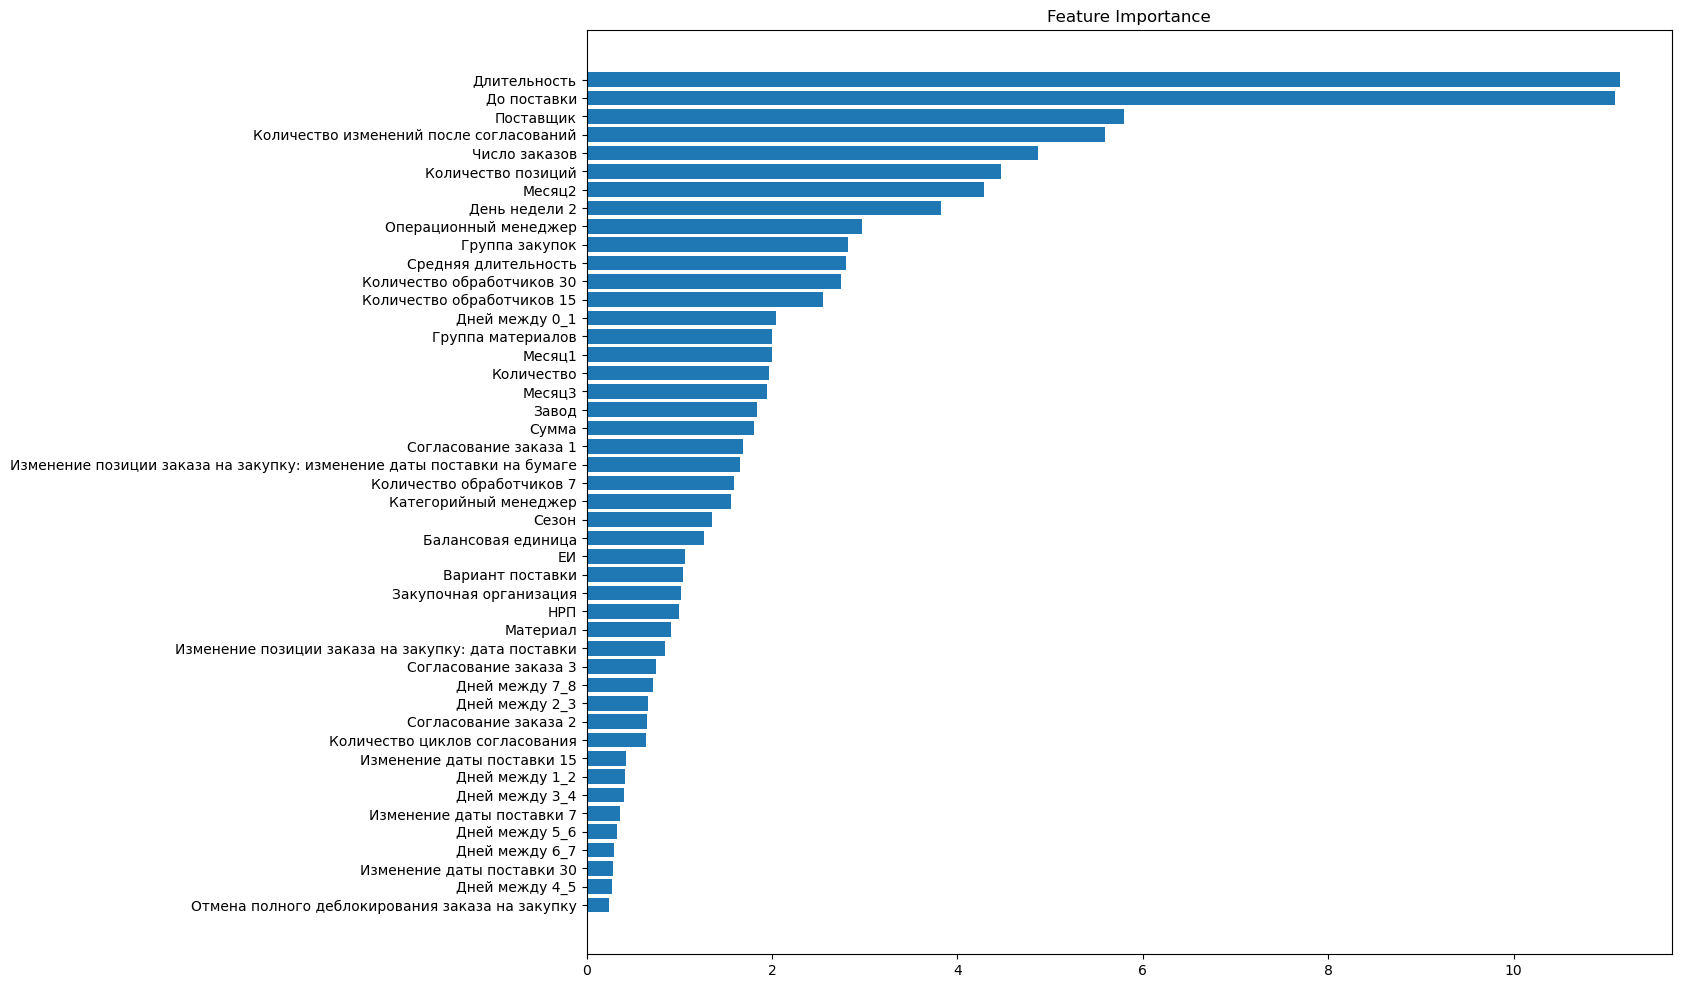

In [164]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(14, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')


### Предсказание модели и последующая запись в submission

In [22]:
submission = pd.read_csv(r'C:\Users\Mops010\Downloads\74abd23d767d00a2fcc9a2cbe53bc4e7 (1).csv')

In [23]:
preds = model.predict(test_df)
preds

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [24]:
submission['value'] = preds
submission.to_csv('submission_1.csv', index=False)